# Main module

In [1]:
import numpy as np

class DB:
    def __init__(self):
        # { "product": { "history": [...], "up_bound": ..., "low_bound": ... } }       
        self._price = {}
        self._qty = {}
        
        self._base_concentration = 0.7

    def add_product(self, product, price, qty, skip_bounds_check=False):
        validation_error = self._validate_params(product, price, qty)
        if not validation_error is None:
            return validation_error

        bounds_error = None if skip_bounds_check else self._check_bounds(product, price, qty)
        if not bounds_error is None:
            return bounds_error

        self._do_add_product(product, price, qty)

        return None

    def prune_outliers(self, product):
        price_record = self._price[product]
        qty_record = self._qty[product]
    
        price_qty_zipped = list(zip(
            price_record["history"],
            qty_record["history"]
        ))

        new_values = [x for x in price_qty_zipped if
                      x[0] >= price_record["low_bound"] and
                      x[0] <= price_record["up_bound"] and
                      x[1] >= qty_record["low_bound"] and
                      x[1] <= qty_record["up_bound"]
                     ]

        new_price, new_qty =  zip(*new_values)
        price_record["history"] = new_price
        qty_record["history"] = new_qty

        self._recalculate_bounds(product)

    def get_price_record(self, product):
        return self._price[product]

    def get_qty_record(self, product):
        return self._qty[product]

    def _do_add_product(self, product, price, qty):
        if not self._price.get(product):
            self._price[product] = self._empty_record()
            self._qty[product] = self._empty_record()
    
        self._price[product]["history"].append(price)
        self._qty[product]["history"].append(qty)
        self._recalculate_bounds(product)

    def _empty_record(self):
        return {
            "mean": 0,
            "up_bound": 0,
            "low_bound": 0,
            "base_dev": 0,
            "up_dev": 0,
            "low_dev": 0,
            "line_slope": 0,
            "history": [],
        }

    def _validate_params(self, product, price, qty):
        if not product:
            return "Invalid product name"

        if price <= 0:
            return "Price should be > 0"
        
        if qty < 0:
            return "Quantity can't be negative"

        return None

    def _check_bounds(self, product, price, qty):
        if not self._price.get(product):
            bounds = self._global_bounds()
    
            if bounds is None:
                return None

            if price < bounds["lowest_price"]:
                return "The price looks too low compared to other products"

            if price > bounds["highest_price"]:
                return "The price looks too high compared to other products"

            if qty < bounds["lowest_qty"]:
                return "The quantity looks too low compared to other products"

            if qty > bounds["highest_qty"]:
                return "The quantity looks too high compared to other products"
        else:
            price_record = self._price[product]
            qty_record = self._qty[product]
            
            if price < price_record["low_bound"]:
                return "The price looks too low compared to historical values for this product"
            
            if price > price_record["up_bound"]:
                return "The price looks too high compared to historical values for this product"
            
            if qty < qty_record["low_bound"]:
                return "The quantity looks too low compared to historical values for this product"
            
            if qty > qty_record["up_bound"]:
                return "The quantity looks too high compared to historical values for this product"
        
        return None

    def _global_bounds(self):
        if len(self._price.keys()) == 0:
            return None

        lowest_price = min([x["low_bound"] for x in self._price.values()])
        highest_price = max([x["up_bound"] for x in self._price.values()])
        lowest_qty = min([x["low_bound"] for x in self._qty.values()])
        highest_qty = max([x["up_bound"] for x in self._qty.values()])

        return {
            "lowest_price": lowest_price,
            "highest_price": highest_price,
            "lowest_qty": lowest_qty,
            "highest_qty": highest_qty
        }

    def _recalculate_bounds(self, product):
        self._price[product] = self._bounds_for_history(self._price[product]["history"])
        self._qty[product] = self._bounds_for_history(self._qty[product]["history"], True)

    def _bounds_for_history(self, history, ignore_dynamics = False):
        mean = np.mean(history)
        var = np.var(history)
        base_dev = np.sqrt(var / (1 - self._base_concentration))
        up_dev = base_dev
        low_dev = base_dev

        slope = None
        if not ignore_dynamics and len(history) > 1:
            [slope, _b] = np.polyfit(range(0, len(history)), history, 1)

            if slope >= 0:
                low_dev -= low_dev * (min(slope, 3) / 3)
            else:
                up_dev -= up_dev * (min(-slope, 3) / 3)

        return {
            "mean": mean,
            "up_bound": mean + up_dev,
            "low_bound": mean - low_dev,
            "base_dev": base_dev,
            "up_dev": up_dev,
            "low_dev": low_dev,
            "line_slope": slope,
            "history": history
        }
  
    

In [2]:
import matplotlib.pyplot as plt

def trend_plot(record):
    history = record["history"]
    plt.xlabel("Value")
    plt.ylabel("Time")
    plt.plot(range(0, len(history)), history)
    plt.grid()

def histogram(record):
    history = record["history"]
    plt.xlabel("Value")
    plt.ylabel("Number of samples")
    plt.hist(history, bins=len(history) // 2)
    plt.axvline(x=record["mean"], linestyle="--", color="red", label="Mean")
    plt.axvline(x=record["up_bound"], linestyle="--", color="orange", label=f"Bounds")
    plt.axvline(x=record["low_bound"], linestyle="--", color="orange")

    plt.grid()
    plt.legend()

# Tests

In [18]:
from random import randint

db = DB()

## Initial data

### "Normal" data

In [19]:
for i in range(0, 50):
    db.add_product(
        "phone",
        randint(100 + i // 2, 100 + i),
        randint(30, 50),
        skip_bounds_check=True
    )

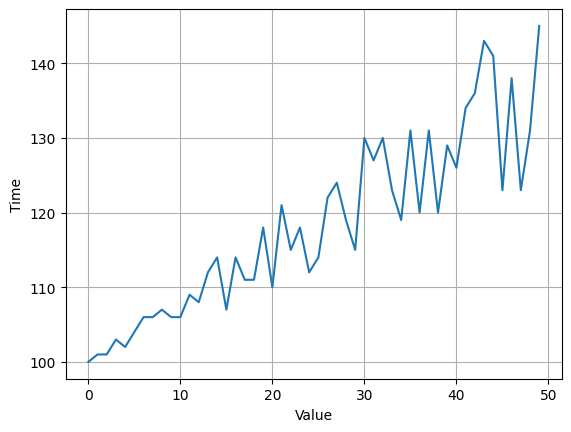

In [21]:
trend_plot(db.get_price_record("phone"))

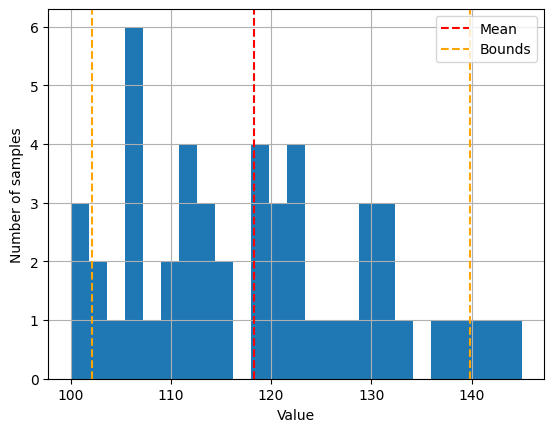

In [22]:
histogram(db.get_price_record("phone"))

In [7]:
db.get_price_record("phone")

{'mean': 118.86,
 'up_bound': 142.64798015805462,
 'low_bound': 101.78215308444875,
 'base_dev': 23.787980158054612,
 'up_dev': 23.787980158054612,
 'low_dev': 17.07784691555125,
 'line_slope': 0.846242496998802,
 'history': [100,
  100,
  102,
  101,
  102,
  102,
  104,
  103,
  108,
  106,
  108,
  111,
  110,
  106,
  107,
  108,
  108,
  113,
  115,
  112,
  113,
  114,
  117,
  114,
  114,
  124,
  113,
  124,
  114,
  124,
  129,
  130,
  126,
  129,
  124,
  124,
  135,
  135,
  123,
  120,
  133,
  125,
  139,
  142,
  144,
  141,
  133,
  147,
  131,
  136]}

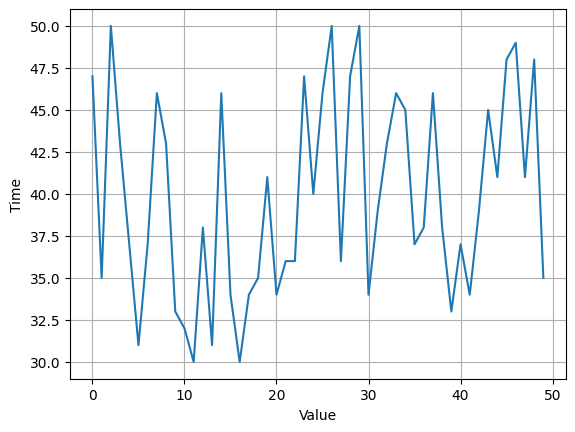

In [24]:
trend_plot(db.get_qty_record("phone"))

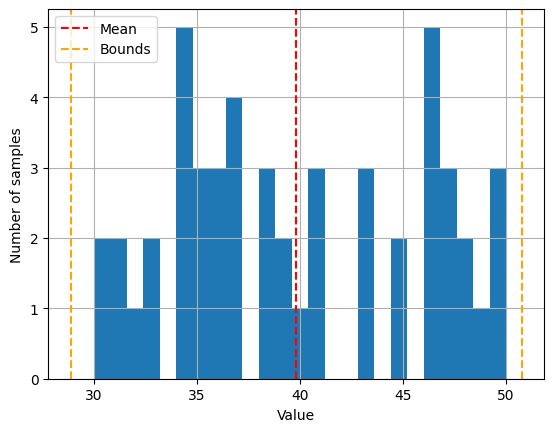

In [26]:
histogram(db.get_qty_record("phone"))

In [10]:
db.get_qty_record("phone")

{'mean': 41.84,
 'up_bound': 52.40005050492974,
 'low_bound': 31.279949495070273,
 'base_dev': 10.56005050492973,
 'up_dev': 10.56005050492973,
 'low_dev': 10.56005050492973,
 'line_slope': None,
 'history': [46,
  43,
  47,
  45,
  49,
  50,
  36,
  36,
  33,
  47,
  44,
  33,
  49,
  50,
  44,
  49,
  47,
  48,
  48,
  49,
  34,
  42,
  30,
  39,
  31,
  35,
  48,
  37,
  46,
  39,
  45,
  44,
  49,
  43,
  43,
  39,
  31,
  41,
  30,
  39,
  46,
  41,
  36,
  44,
  44,
  44,
  37,
  44,
  40,
  38]}

### Introducing outliers

In [28]:
# Price outliers
for i in range(0, 5):
    qty = randint(30, 50)
    db.add_product(
        "phone",
        randint(200, 300),
        qty,
        skip_bounds_check=True
    )

    db.add_product(
        "phone",
        randint(20, 50),
        qty,
        skip_bounds_check=True
    )

# Qty outliers
for i in range(0, 5):
    price = randint(100 + i // 2, 100 + i)

    db.add_product(
        "phone",
        price,
        randint(1, 10),
        skip_bounds_check=True
    )
    
    db.add_product(
        "phone",
        price,
        randint(90, 100),
        skip_bounds_check=True
    )

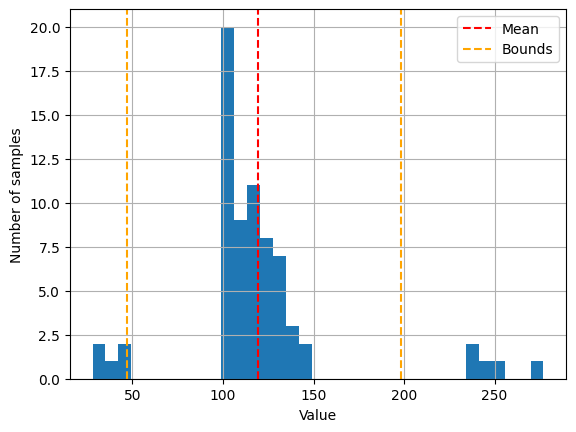

In [29]:
histogram(db.get_price_record("phone"))

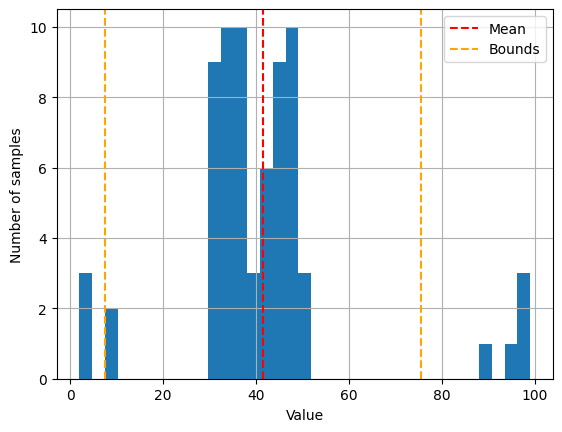

In [30]:
histogram(db.get_qty_record("phone"))

### Pruning outliers

In [31]:
db.prune_outliers("phone")

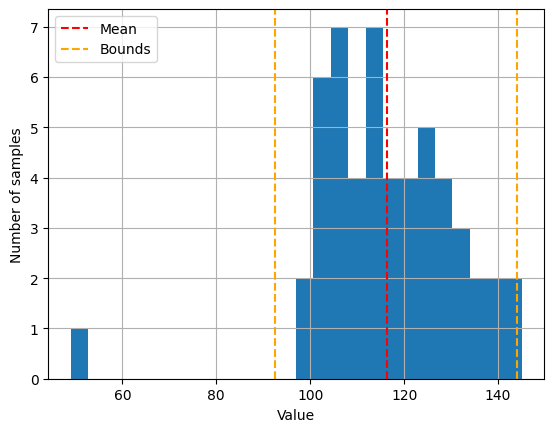

In [32]:
histogram(db.get_price_record("phone"))

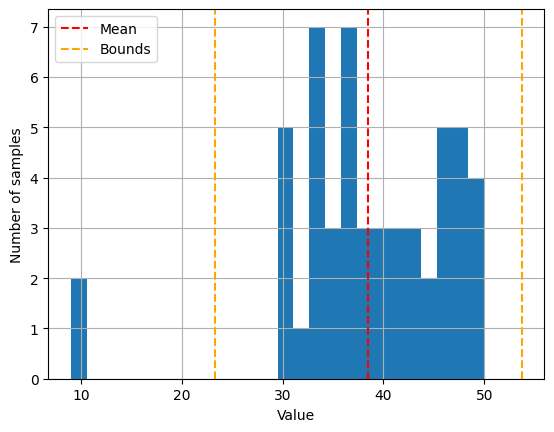

In [33]:
histogram(db.get_qty_record("phone"))

## Adding new product

### Milk

In [34]:
db.add_product("milk", 8, 500)

'The price looks too low compared to other products'

In [35]:
db.add_product("milk", 100, 800)

'The quantity looks too high compared to other products'

In [36]:
db.add_product("milk", 8, 500, skip_bounds_check=True)

In [37]:
db.add_product("milk", 8.5, 300, skip_bounds_check=True)

In [38]:
db.add_product("milk", 5, 350, skip_bounds_check=True)

In [40]:
db.add_product("milk", 85, 400)

'The price looks too high compared to historical values for this product'

In [41]:
db.add_product("milk", 7, 5)

'The quantity looks too low compared to historical values for this product'

### Bread

In [43]:
db.add_product("bread", 2.1, 1000)

'The price looks too low compared to other products'

In [44]:
db.add_product("bread", 5, 1000)

'The quantity looks too high compared to other products'

In [45]:
db.add_product("bread", 2.1, 1000, skip_bounds_check=True)

In [46]:
db.add_product("bread", 5, 500, skip_bounds_check=True)

In [48]:
db.add_product("bread", 3, 400)

'The price looks too low compared to historical values for this product'

In [49]:
db.add_product("bread", 3, 400, skip_bounds_check=True)

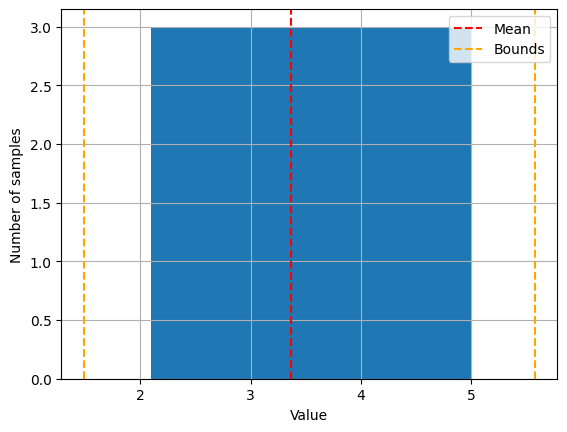

In [50]:
histogram(db.get_price_record("bread"))